# TebakGaji Notebook

In [1]:
import os
os.chdir('..')

In [80]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import constants
from src.tuner import tune_catboost_cv
from src.data import (
    normalize_salary_to_million_idr_monthly,
    read_raw, clean_data, clean_company, clean_country,
    clean_city, clean_role
)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import make_scorer, mean_squared_error as mse
from sklearn.model_selection import KFold, cross_validate

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
DATA_PATH = 'datasets/data.html'

raw_data = read_raw(DATA_PATH)
raw_data.head()

,role,company,years_of_exp,city,country,gender,currency,salary,mode,period,compensation,verified
0,tester,Purchase to unlock 👆,3,Bandung,ID,Male,IDR,30000000,Net,Monthly,RSU so stonks.,Verified
1,HES Engineer,Purchase to unlock 👆,12,Pekanbaru,ID,Male,IDR,54000000,Gross,Monthly,*Vacation allowance = 1 month salary *Full med...,NaN
2,Lead Front End,Purchase to unlock 👆,5,Jakarta,ID,Male,IDR,16500000,Gross,Monthly,NaN,NaN
3,Android Developer,Purchase to unlock 👆,5,Jakarta,ID,Male,IDR,23500000,Gross,Monthly,"Insurance, work from home.",NaN
4,dats scientist,Purchase to unlock 👆,6,jakarta,ID,Male,IDR,14600000,Net,Monthly,NaN,NaN


# Cleaning

In [82]:
df = clean_data(raw_data)
print('Data shape:', df.shape)

df.head(1)

Data shape: (500, 9)


,role,company,years_of_exp,city,country,gender,salary,compensation,verified
0,tester,other,3,bandung,ID,male,30.0,rsu so stonks.,Verified


# Exploration

## Num of Unique Values

In [83]:
categorical_cols = ['role', 'company', 'years_of_exp', 'city', 'country', 'gender']
nunique_values = df[categorical_cols].nunique()
print(nunique_values)
print('Total:', nunique_values.sum())

role            289
company           6
years_of_exp     17
city             60
country           5
gender            3
dtype: int64
Total: 380


## Categorical Feature Distribution

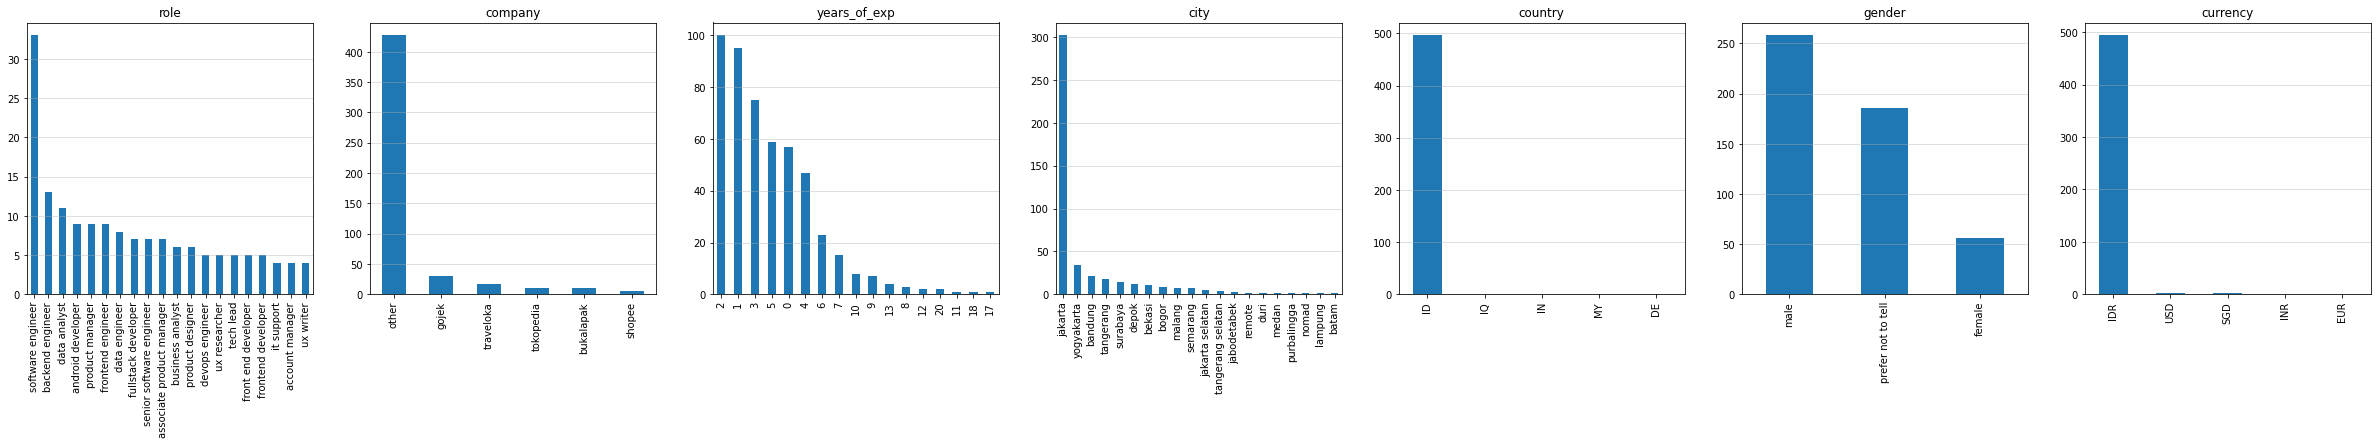

In [7]:
top = 20
cols = ['role', 'company', 'years_of_exp', 'city', 'country', 'gender', 'currency']
fig, ax = plt.subplots(1, len(cols), figsize=(len(cols) * 6, 5))

for i, col in enumerate(cols):
    temp_data = df[col].value_counts()[:top]
    temp_data.plot(kind='bar', ax=ax[i])
    ax[i].set_title(col)
    ax[i].grid(axis='y', alpha=0.5)

plt.show()

<AxesSubplot:xlabel='years_of_exp', ylabel='salary'>

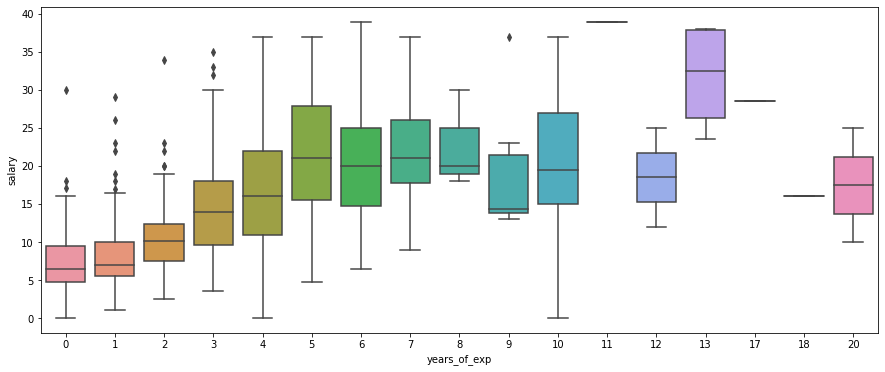

In [57]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='years_of_exp', y='salary')

In [84]:
df[df.city == 'remote']

,role,company,years_of_exp,city,country,gender,salary,compensation,verified
402,software engineer,other,3,remote,ID,prefer not to tell,8.0,NaN,NaN
409,associate software developer,other,1,remote,ID,male,7.5,"pajak, bpjs",NaN


## Salary Distribution

C:\Users\rerlan01\Desktop\temp_rimba\predict_salary\env\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


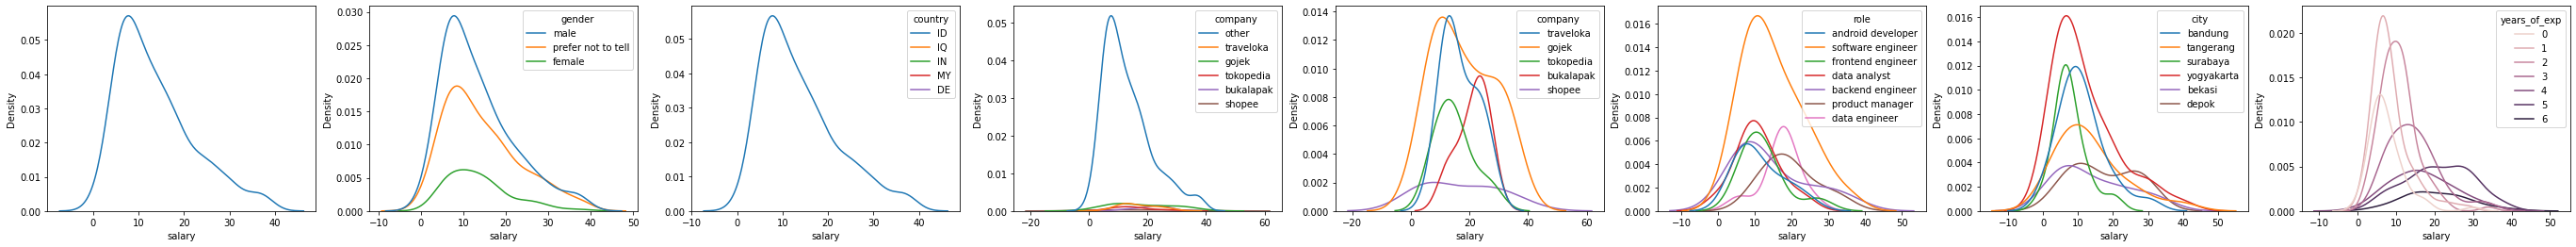

In [8]:
n_rows = 8
top = 7
fig, ax = plt.subplots(1, n_rows, figsize=(6 * n_rows, 4))

def kdeplot(data, ax, x='salary', hue=None):
    sns.kdeplot(x=x, data=data, ax=ax, hue=hue)

kdeplot(ax=ax[0], data=df)
kdeplot(ax=ax[1], data=df, hue='gender')
kdeplot(ax=ax[2], data=df, hue='country')
kdeplot(ax=ax[3], data=df, hue='company')
kdeplot(ax=ax[4], hue='company', data=df[df.company != 'other'])
kdeplot(ax=ax[5], hue='role', data=df[df.role.isin(df.role.value_counts().index[:top])])
kdeplot(ax=ax[6], hue='city', data=df[df.city.isin(df.city.value_counts().index[1:top])])
kdeplot(ax=ax[7], hue='years_of_exp',
        data=df[df.years_of_exp.isin(df.years_of_exp.value_counts().index[:top])])

plt.show()

## Salary vs Years of Exp

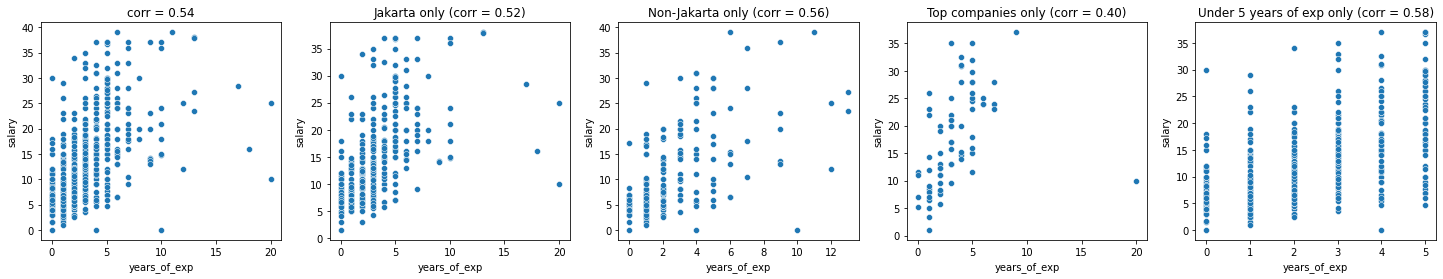

In [79]:
n_rows = 5
fig, ax = plt.subplots(1, n_rows, figsize=(5 * n_rows, 4))

def plot_scatter(data, ax, x='years_of_exp', y='salary', title=None):
    sns.scatterplot(x=x, y=y, data=data, ax=ax)
    
    corr = data[[x, y]].corr().loc[x, y]
    corr = f'corr = {corr:.2f}'
    title = title + f' ({corr})' if title != None else corr
    ax.set_title(title)

plot_scatter(ax=ax[0], data=df)
plot_scatter(ax=ax[1], data=df[df.city == 'jakarta'], title='Jakarta only')
plot_scatter(ax=ax[2], data=df[df.city != 'jakarta'], title='Non-Jakarta only')
plot_scatter(ax=ax[3], data=df[df.company != 'other'], title='Top companies only')
plot_scatter(ax=ax[4], data=df[df.years_of_exp <= 5], title='Under 5 years of exp only')

# Modeling

## Baseline: CatBoost

### Config

In [13]:
# config
seed = 0
early_stopping_rounds = 200
n_splits = 5
n_trials = 5
timeout = 30
verbose = 0
direction = 'maximize'

rmse = lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred))
scoring = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
fit_params = dict(early_stopping_rounds=early_stopping_rounds, verbose=verbose)
cv_params = dict(cv=cv, fit_params=fit_params, scoring=scoring)

### Hyperparameter Tuning Setup

In [173]:
def params_func(trial):
    param = {
        "depth": trial.suggest_int("depth", 1, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 3, 6),
        "colsample_bylevel": trial.suggest_float(
            "colsample_bylevel", 0.01, 0.1
        ),
        "boosting_type": trial.suggest_categorical(
            "boosting_type",
            ["Ordered", "Plain"]
        ),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type",
            ["Bayesian", "Bernoulli", "MVS"]
        )
    }

    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 10
        )
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    return param

### Default Features

In [21]:
print('\nBaseline model')
df = clean_data(raw_data)

feature_cols = ['role', 'company', 'years_of_exp', 'city', 'country', 'gender']
cat_features = [0, 1, 3, 4, 5]
X, y = df[feature_cols], df.salary
print('Data shape:', X.shape)

clf_params = dict(cat_features=cat_features, random_seed=seed)
best_params, study = tune_catboost_cv(
    X, y, params_func, seed=seed, n_trials=n_trials, timeout=timeout,
    cv_params=cv_params, clf_params=clf_params, direction=direction
)


Baseline model
Data shape: (500, 6)

Best Score: -6.444686769058985
> Finished in: 39.62s
> Number of completed trials: 2
> Best Params: 
{
    "depth": 6,
    "learning_rate": 0.03766576841599294,
    "l2_leaf_reg": 0.16051911333587626,
    "min_data_in_leaf": 12,
    "one_hot_max_size": 4,
    "colsample_bylevel": 0.06813047017599906,
    "boosting_type": "Plain",
    "bootstrap_type": "Bayesian",
    "bagging_temperature": 5.288949197529044
}

> Done cross-validating in: 16.92s
Refitted CV score: -6.444686769058985


## Feature Engineering

In [11]:
df.head()

,role,company,years_of_exp,city,country,gender,currency,salary,mode,period,compensation,verified
0,tester,other,3,bandung,ID,male,IDR,30.00,Net,Monthly,rsu so stonks.,Verified
1,lead front end,other,5,jakarta,ID,male,IDR,16.50,Gross,Monthly,NaN,NaN
2,android developer,other,5,jakarta,ID,male,IDR,23.50,Gross,Monthly,"insurance, work from home.",NaN
3,dats scientist,other,6,jakarta,ID,male,IDR,14.60,Net,Monthly,NaN,NaN
4,software engineer,other,2,tangerang,ID,male,IDR,13.75,Net,Monthly,private insurance,NaN


### Clean `city` and Drop `gender`

In [85]:
print('\nClean `city` and drop `gender`')
df = clean_data(raw_data)
df.city = df.apply(clean_city, axis=1)

feature_cols = ['role', 'company', 'country', 'city', 'years_of_exp']
cat_features = [0, 1, 2, 3, 4]
X, y = df[feature_cols], df.salary
print('Data shape:', X.shape)

clf_params = dict(cat_features=cat_features, random_seed=seed)
best_params, study = tune_catboost_cv(
    X, y, params_func, seed=seed, n_trials=n_trials, timeout=timeout,
    cv_params=cv_params, clf_params=clf_params, direction=direction
)


Clean `city` and drop `gender`
Data shape: (500, 5)

Best Score: -6.554664999899154
> Finished in: 50.31s
> Number of completed trials: 2
> Best Params: 
{
    "depth": 6,
    "learning_rate": 0.03766576841599294,
    "l2_leaf_reg": 0.16051911333587626,
    "min_data_in_leaf": 12,
    "one_hot_max_size": 4,
    "colsample_bylevel": 0.06813047017599906,
    "boosting_type": "Plain",
    "bootstrap_type": "Bayesian",
    "bagging_temperature": 5.288949197529044
}

> Done cross-validating in: 19.59s
Refitted CV score: -6.554664999899154


In [87]:
df[df.city == 'remote']

,role,company,years_of_exp,city,country,gender,salary,compensation,verified
209,software engineer,other,4,remote,ID,prefer not to tell,26.0,NaN,NaN
211,ios developer,other,1,remote,ID,prefer not to tell,15.0,NaN,NaN
374,frontend engineer,other,1,remote,ID,male,8.0,NaN,NaN
402,software engineer,other,3,remote,ID,prefer not to tell,8.0,NaN,NaN
409,associate software developer,other,1,remote,ID,male,7.5,"pajak, bpjs",NaN


### Bag of Words: `role`

In [89]:
print('\nBag of words: `role`')
df = clean_data(raw_data)
df.city = df.apply(clean_city, axis=1)
df.role = df.apply(clean_role, axis=1)

# extract token count
vec = CountVectorizer(binary=True)
vec.fit(df.role)
role_binary = pd.DataFrame(
    vec.transform(df.role).toarray(),
    columns=vec.get_feature_names_out()
)

# prepare data
cols = ['company', 'city', 'years_of_exp']
X, y = pd.concat([role_binary, df[cols]], axis=1), df.salary
cat_features = np.where(X.columns != 'years_of_exp')[0]
print('Data shape:', X.shape)

clf_params = dict(cat_features=cat_features, random_seed=seed)
best_params, study = tune_catboost_cv(
    X, y, params_func, seed=seed, n_trials=n_trials, timeout=timeout,
    cv_params=cv_params, clf_params=clf_params, direction=direction
)


Bag of words: `role`
Data shape: (500, 214)

Best Score: -6.183491569701294
> Finished in: 46.53s
> Number of completed trials: 1
> Best Params: 
{
    "depth": 6,
    "learning_rate": 0.03766576841599294,
    "l2_leaf_reg": 0.16051911333587626,
    "min_data_in_leaf": 12,
    "one_hot_max_size": 4,
    "colsample_bylevel": 0.06813047017599906,
    "boosting_type": "Plain",
    "bootstrap_type": "Bayesian",
    "bagging_temperature": 5.288949197529044
}

> Done cross-validating in: 46.11s
Refitted CV score: -6.183491569701294


In [186]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from catboost import CatBoostRegressor
from optuna.samplers import TPESampler

import optuna

cols = ['role', 'company', 'city', 'years_of_exp']
X, y = df[cols], df.salary

def toarray(x):
    return x.toarray()

def objective(trial):
    min_df = trial.suggest_float('min_df', 0.01, 0.2)
    
    prep = Pipeline(steps=[
        ("squeeze", FunctionTransformer(np.squeeze)),
        ("vect", CountVectorizer(binary=True, min_df=min_df)),
        ("toarray", FunctionTransformer(toarray)),
    ])

    col_transform = ColumnTransformer(
        [('prep', prep, ['role'])],
        remainder='passthrough',
    )

    col_transform.fit(X, y)
    col_number = col_transform.output_indices_['remainder'].stop
    cat_features = list(range(col_number - 1))
    clf_params = dict(cat_features=cat_features, random_seed=seed)
    fit_params = dict(model__early_stopping_rounds=early_stopping_rounds, model__verbose=verbose)
    cv_params = dict(cv=cv, fit_params=fit_params, scoring=scoring)
    
    param = params_func(trial)
    model = Pipeline(steps=[
        ('trans', col_transform),
        ('model', CatBoostRegressor(**{**param, **clf_params}))
    ])
    cv_results = cross_validate(model, X, y, **cv_params)
    return cv_results['test_score'].mean()

study = optuna.create_study(sampler=TPESampler(seed=seed), direction=direction)
study.optimize(objective, n_trials=n_trials, timeout=timeout)

C:\Users\rerlan01\Desktop\temp_rimba\predict_salary\env\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2181, in _catboost.get_float_feature
  File "_catboost.pyx", line 1126, in _catboost._FloatOrNan
  File "_catboost.pyx", line 949, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'bandung'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rerlan01\Desktop\temp_rimba\predict_salary\env\lib\site-packages\sklearn\model_selectio